### Assignment 2

Deadline: 8 February.

**Question 1:** This question is about learning to use the VTK library. The idea is to implement a simple Grid class that allows to import triangle elements and vertices from vtk files and to export them to vtk files. The skeleton of the class is given as follows:

In [1]:
class Grid(object):
    """This class implements access to triangular grids."""

    def __init__(self, vertices, elements):
        """
        Initialize a grid.

        This routine takes an Nx2 Numpy array of N vertices
        and a Mx3 Numpy array with corresponding M elements.
        """
        import numpy as np

        if not (isinstance(vertices, np.ndarray) and
                isinstance(elements, np.ndarray)):
            raise ValueError("The input data must be of type numpy.ndarray.")
        self.__vertices = vertices
        self.__elements = elements

        # Some protection against modifying the grid data externally
        self.__vertices.setflags(write=False)
        self.__elements.setflags(write=False)

    @classmethod
    def from_vtk_file(cls, filename):
        """Create a grid from a given vtk file."""

        # Insert code that reads a grid from a vtk file.
        # For this you should look up the VtkUnstructuredGridReader class.
        # Make sure that you only import triangular elements (check the vtk cell type).
        # VTK only knows vertices in 3 dimensions. Simply ignore the
        # z-coordinate.

        import os.path
        import vtk
        import numpy as np

        if not os.path.isfile(filename):
            raise ValueError("File does not exist.")

        # Reads the vtk file and stores the result in the output variable
        reader = vtk.vtkUnstructuredGridReader()
        reader.SetFileName(filename)
        reader.Update()
        output = reader.GetOutput()

        # Extracts the x and y coordinates of the points
        # and creates an array of points.
        points = np.array(output.GetPoints().GetData())
        points = points[:, :2]
        numberOfCells = output.GetNumberOfCells()

        # Extracts the point Ids from each cell and creates an
        # array of elements containing point Ids.
        i = 0
        first = True
        while i < numberOfCells:
            cell = output.GetCell(i)
            if cell.GetCellType() == 5:
                numpyCell = np.array([cell.GetPointId(0),
                                      cell.GetPointId(1),
                                      cell.GetPointId(2)])
                if first:
                    elements = numpyCell
                    first = False
                else:
                    elements = np.vstack([elements, numpyCell])
            i += 1

        return cls(points, elements)

    @property
    def number_of_vertices(self):
        """Return the number of vertices."""
        return self.__vertices.shape[0]

    @property
    def number_of_elements(self):
        """Return the number of elements."""
        return self.__elements.shape[0]

    @property
    def vertices(self):
        """Return the vertices."""
        return self.__vertices

    @property
    def elements(self):
        """Return the elements."""
        return self.__elements

    def get_corners(self, element_id):
        """Return the 3x2 matrix of corners associated with an element."""
        import numpy as np
        element = self.__elements[element_id]
        first = True
        for point_id in element:
            if first:
                corners = self.__vertices[point_id]
                first = False
            else:
                corners = np.vstack([corners, self.__vertices[point_id]])
        return corners

    def get_jacobian(self, element_id):
        """Return the jacobian associated with a given element id."""
        import numpy as np
        corners = self.get_corners(element_id)
        jacobian = np.vstack([corners[1] - corners[0],
                              corners[2] - corners[0]]).transpose()
        return jacobian

    def export_to_vtk(self, fname, point_data=None):
        """Export grid to a vtk file. Optionally also export point data."""
        from vtk import vtkUnstructuredGrid, vtkPointData, vtkDoubleArray, \
            vtkPoints, vtkUnstructuredGridWriter, VTK_TRIANGLE

        grid = vtkUnstructuredGrid()

        if point_data is not None:

            data = grid.GetPointData()
            scalar_data = vtkDoubleArray()
            scalar_data.SetNumberOfValues(len(point_data))
            for index, value in enumerate(point_data):
                scalar_data.SetValue(index, value)
            data.SetScalars(scalar_data)

        points = vtkPoints()
        points.SetNumberOfPoints(self.number_of_vertices)
        for index in range(self.number_of_vertices):
            points.InsertPoint(
                index,
                (self.vertices[index, 0], self.vertices[index, 1], 0))

        grid.SetPoints(points)

        for index in range(self.number_of_elements):
            grid.InsertNextCell(
                VTK_TRIANGLE, 3,
                [self.elements[index, 0], self.elements[index, 1],
                 self.elements[index, 2]]
            )

        writer = vtkUnstructuredGridWriter()
        writer.SetFileName(fname)
        writer.SetInputData(grid)
        writer.Write()

        return grid

Once you have implemented the grid class it is time to test it. For testing use the following commands.

In [2]:
grid = Grid.from_vtk_file('lshape.vtk')

In [3]:
print("Verticies of element 50: \n{}\n".format(grid.vertices[0]))
print("Points Ids of element 50: \n{}\n".format(grid.elements[50]))
print("Corners of element 50: \n{}\n".format(grid.get_corners(50)))
print("Jacobian of element 50: \n{}\n".format(grid.get_jacobian(50)))

Verticies of element 50: 
[-0.  0.]

Points Ids of element 50: 
[494 212 502]

Corners of element 50: 
[[0.96875 0.71875]
 [0.9375  0.6875 ]
 [0.96875 0.65625]]

Jacobian of element 50: 
[[-0.03125  0.     ]
 [-0.03125 -0.0625 ]]



**Question 2:**

We want to implement a finite difference method for the wave equation $u_{tt} = c^2u_{xx}$ for $c=1$ and $(t, x) \in [0, 1]\times [0, 2]$. The boundary conditions are $u(0, x) = e^{-5(x-.5)^2}$ and $\frac{\partial}{\partial n} u = 0$ otherwise.
The method should simply use central difference discretizations in space and time.

Your implementation should be written in OpenCL. Below you find a simple Numpy implementation that can serve as a template. Produce a plot of your result to demonstrate correctness.

Elapsed time (s): 0.31740689277648926


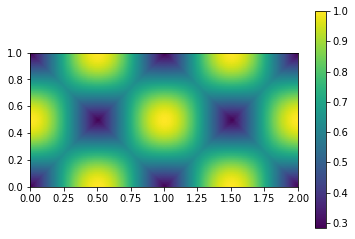

In [23]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

def solve_wave_equation(N, time_steps, c=1, T=1):
    """
    Solves a 1d wave equation.

    This function solves the 1d wave equation
    with zero boundary conditions. The x-domain is the
    interval [0, 1] and the final time is T.
    """

    xt_grid = np.zeros((N, time_steps + 1), dtype='float64')
    xx = np.linspace(0, 1, N)

    # Set initial condition
    xt_grid[:, 0] = np.exp(-5 * (xx-.5)**2)

    dt = T / (1.0 * time_steps)
    dx = 1. / (N - 1)

    # Compute courant number
    C = c * dt / dx
#    print("Courant Number: {0}".format(C))

    # Set first step

    for index in range(0, N):
        il = 1 if index == 0 else index - 1
        ir = N - 2 if index == N - 1 else index + 1
        xt_grid[index, 1] = xt_grid[index, 0] - \
            .5 * C**2 * (xt_grid[ir, 0] - 2 * xt_grid[index, 0]
                + xt_grid[il, 0])

    # Compute the other steps

    for t_index in range(1, time_steps ):
        for x_index in range(0, N):
            il = 1 if x_index == 0 else x_index - 1
            ir = N - 2 if x_index == N - 1 else x_index + 1
            xt_grid[x_index, t_index + 1] = \
                (- xt_grid[x_index, t_index - 1] + 2 * xt_grid[x_index, t_index] +
                 C**2 * (xt_grid[ir, t_index] -
                 2 * xt_grid[x_index, t_index] +
                 xt_grid[il, t_index]))

    return xt_grid

from time import time

T = 2
st = time()
res = solve_wave_equation(200, 500, c=1, T=T)
et = time()
print("Elapsed time (s): {0}".format(et - st))

plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()


Elapsed time (s): 0.5833730697631836


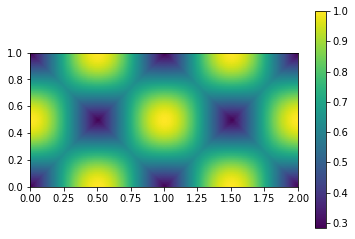

In [29]:
import numpy as np
import pyopencl as cl
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)


def solve_wave_equation(N, time_step, c=1, T=1):
    """OpenCL Implementation

    Solves a 1d wave equation.
    This function solves the 1d wave equation
    with zero boundary conditions. The x-domain is the
    interval [0, 1] and the final time is T.
    """
    # Defines the xt matrix and the x array
    xt_grid = np.zeros((N, time_step + 1), dtype='float64')
    xx = np.linspace(0, 1, N)

    # Calculates all the x values at t = 0 for the xt matrix
    xt_grid[:, 0] = np.exp(-5 * (xx - 0.5) ** 2)

    # Calculates the finite differences of x and t
    dt = T / (1.0 * time_step)
    dx = 1. / (N - 1)

    # Calculates the Courant number
    C = c * dt / dx

    kernel = """
    __kernel void solve_wave_equation(const int time_step,
                                      const int N,
                                      const double C,
                                      const int t_id,
                                      __global double *xt_grid,
                                      __global double *result_buffer)
    {
        int x_id = get_global_id(0);
        
        // Defines the index to the left of the current index
        int il = x_id - 1;
        if (x_id == 0) {
            il = 1;
        }
        
        // Defines the index to the right of the current index
        int ir = x_id + 1;
        if (x_id == (N - 1)) {
            ir = N - 2;
        }
        
        if (t_id == 0) {
            result_buffer[x_id] = xt_grid[x_id * (time_step)] -
                                  0.5 * C* C *(xt_grid[ir * (time_step)] -
                                  2 * xt_grid[x_id * (time_step)] +
                                  xt_grid[il * (time_step) ]);
        } else {
            result_buffer[x_id] = (- xt_grid[(time_step) * x_id + t_id - 1] +
                                  2 * xt_grid[(time_step) * x_id + t_id] +
                                  (C * C * (xt_grid[(time_step) * ir + t_id] -
                                  2 * xt_grid[(time_step) * x_id + t_id] +
                                  xt_grid[(time_step) * il + t_id])));
        }

    }

    """

    prg = cl.Program(ctx, kernel)
    prg.build()
    wave_equation_kernel = prg.solve_wave_equation
    mf = cl.mem_flags

    # Loops over all the time steps and solves the wave equation
    for t_id in range(0, time_step):
        # Assigns the buffer to the grid
        xt_grid_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY,
                                   hostbuf=xt_grid)

        # Assigns the buffer for the result
        result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR,
                                  size=(N) * 8)

        # Calls the function defined in the kernel
        wave_equation_kernel(queue, (N, ), (1, ), np.int32(time_step + 1),
                             np.int32(N), np.float64(C), np.int32(t_id),
                             xt_grid_buffer, result_buffer)

        # Places the result into the matrix
        xt_grid[:, t_id + 1] = cl.enqueue_map_buffer(queue, result_buffer,
                                                     cl.map_flags.READ, 0,
                                                     (N, ), np.double)[0]
    queue.finish()

    return xt_gridk


from time import time

T = 2
st = time()
res = solve_wave_equation(200, 500, c=1, T=T)
et = time()
print("Elapsed time (s): {0}".format(et - st))

plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()